# Programming Exercise 2:Logistic Regression 

$$Machine Learning$$

## Introduction
In this exercise, you will implement logistic regression and apply it to two different datasets. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

## 1.Logistic Regression

In this part of the exercise, you will build a logistic regression model to predict whether a student gets admitted into a university.
Suppose that you are the administrator of a university department and you want to determine each applicant's chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant's scores on two exams and the admissions decision.
Your task is to build a classification model that estimates an applicant's probability of admission based the scores from those two exams.


In [193]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
#这个是优化和拟合函数库
#scipy.optimization子模块提供了函数最小值(标量或多维)、
#曲线拟合和寻找等式的根的有用算法.
from scipy.optimize import minimize

%matplotlib inline

## 1.1 Visualizing the data
Before starting to implement any learning algorithm, it is always good to visualize the data if possible. In the first part, the code will load the data and display it on a 2-dimensional plot by calling the function plotData.
You will now complete the code in plotData so that it displays a figure of the data, where the axes are the two exam scores, and the positive and negative examples are shown with different markers.

In [194]:
#进行算法前先可视化数据
#load Data
# -column 1:score of first exam
# -column 2:score of second exam
# -column 3:admission
data=np.loadtxt('ex2data1.txt',delimiter=',')


#Split data into X and y
X,y=np.hsplit(data,np.array([2]))
"""
print(X.shape)
print(y.shape)
theta = theta.reshape((theta.shape[0],1))
y = y.reshape((y.shape[0],1))
print(theta)
print(y)
"""

#Print out some data points
print("First 10 examples from the dataset:")
for i in range(10):
    print("X = " + str(X[i,:]) + ", y = " + str(y[i]))

First 10 examples from the dataset:
X = [ 34.62365962  78.02469282], y = [ 0.]
X = [ 30.28671077  43.89499752], y = [ 0.]
X = [ 35.84740877  72.90219803], y = [ 0.]
X = [ 60.18259939  86.3085521 ], y = [ 1.]
X = [ 79.03273605  75.34437644], y = [ 1.]
X = [ 45.08327748  56.31637178], y = [ 0.]
X = [ 61.10666454  96.51142588], y = [ 1.]
X = [ 75.02474557  46.55401354], y = [ 1.]
X = [ 76.0987867   87.42056972], y = [ 1.]
X = [ 84.43281996  43.53339331], y = [ 1.]


In [195]:
#我用的这种方法，没有用scatter
"""
#Part 1:Plotting
#We start the exercise by first plotting the data to understand the 
#the problem we are working with.
print("Plotting data with + indicating (y=1) examples and o indicating (y=0) examples.\n")
y = y.ravel()
fig,ax = plt.subplots()
y_pos = y==1
y_neg = y==0
ax.plot(X[y_pos,0],X[y_pos,1],'r+',label="Admitted")
ax.plot(X[y_neg,0],X[y_neg,1],'ko',label='Not admitted')
ax.set_xlabel("Exam 1 score")
ax.set_ylabel("Exam 2 score")
ax.legend(loc='upper right')
"""

'\n#Part 1:Plotting\n#We start the exercise by first plotting the data to understand the \n#the problem we are working with.\nprint("Plotting data with + indicating (y=1) examples and o indicating (y=0) examples.\n")\ny = y.ravel()\nfig,ax = plt.subplots()\ny_pos = y==1\ny_neg = y==0\nax.plot(X[y_pos,0],X[y_pos,1],\'r+\',label="Admitted")\nax.plot(X[y_neg,0],X[y_neg,1],\'ko\',label=\'Not admitted\')\nax.set_xlabel("Exam 1 score")\nax.set_ylabel("Exam 2 score")\nax.legend(loc=\'upper right\')\n'

In [196]:
def plotData(X,y,x1label='Admitted',x2label='Not admitted'):
    """
    'plotData' plots the data points X and y into a new figure.It will 
    plot the data points with + for the positive examples and o for the 
    negative examples. X is assumed to be a Mx2 matrix.
    """
    #Get the indices of positive and negative examples
    pos = np.squeeze(y == 1)#注意pos的输出形式
    neg = np.squeeze(y == 0)
    #这里用到了布尔索引
    plt.scatter(X[pos][:,0],X[pos][:,1], c='k',marker='+',label=x1label)
    plt.scatter(X[neg][:,0],X[neg][:,1], c='r',marker='o',label=x2label)
    plt.title("Scatter plot of training data")
    plt.xlabel("Exam 1 score")
    plt.ylabel("Exam 2 score")
    plt.legend(loc='upper right')#这个可以调label的位置

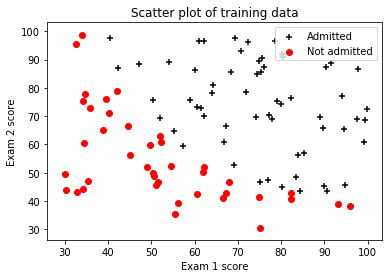

In [197]:
#Visualize the data
plotData(X,y)
plt.show()

## 1.2 Implementation
### 1.2.1 Warmup exercise:sigmoid function
Before you start with the actual cost function, recall that the logistic regression hypothesis is defined as:
$${h}_{\theta}(x) = g({\theta}^{T}x)$$

where function g is the sigmoid function. The sigmoid function is defined as:
$$g(z) = \frac{1}{1+{e}^{-z}}$$

Your first step is to implement `sigmoid` function so it can be called by the rest of your program. When you are finished, try testing a few values by calling `sigmoid(x)`. For large positive values of `x`, the sigmoid should be close to 1, while for large negative values, the sigmoid should be close to 0. Evaluating `sigmoid(0)` should give you exactly 0.5. Your code should also work with vectors and matrices. **For a matrix, your function should perform the sigmoid function on every element.**

In [198]:
def sigmoid(z):
    """
    Instructions:Compute the sigmoid of each value of z (
    z can be a matrix,vector or scalar).
    Return sigmoid(x) = 1/(1+e^(-z))
    """
    g = 1 / (1 + np.exp(-z))
    return g

In [199]:
#Test sigmoid
z=np.array([[-10,0],[0,10]])
g=sigmoid(z)
print("sigmoid([[-10,0],[0,10]]) = " + str(g))
print(g.shape)
print(type(g))

sigmoid([[-10,0],[0,10]]) = [[  4.53978687e-05   5.00000000e-01]
 [  5.00000000e-01   9.99954602e-01]]
(2, 2)
<class 'numpy.ndarray'>


### 1.2.2 Cost function and gradient
Now you will implement the cost function and gradient for logistic regression.Complete the code in costFunction.m to return the cost and gradient.Recall that the cost function in logistic regression is
$$J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}[{y}^{(i)}\log({h}_{\theta}({x}^{(i)}))+(1-{y}^{(i)})\log(1-{h}_{\theta}({x}^{(i)}))]$$
and the gradient of the cost is a vector of the same length as $\theta$ where the ${j}^{th}$ element(for j=0,1,...,n) is defined as follows:
$$\frac{\partial J(\theta)}{\partial {\theta}_{j}} = \frac{1}{m}\sum_{i=1}^{m}({h}_{\theta}({x}^{(i)})-{y}^{(i)}){{x}_{j}}^{(i)}$$

Note that while this gradient looks identical to the linear regression gradient,the formula is actually different because linear and logistic regression have different definitions of ${h}_{\theta}(x)$.

Once you have done,the code will call your costFunction using the initial parameters of $\theta$.
You should see that the cost is about 0.693.

In [200]:
def costFunction(theta,X,y):
    """
    'J,grad = costFunction(X,y,theta)' computes the cost of using theta
    as the parameters for logistic regression and the gradient of the
    cost w.r.t to the parameters.
    """
    #Arguments theta and y may be rank 1 array
    theta = theta.reshape((theta.shape[0],1))
    y = y.reshape((y.shape[0],1))
    
    #Initialize the number of training examples
    m = X.shape[0]
    
    #Compute the cost J
    J=-1*(np.dot(y.T,np.log(sigmoid(np.dot(X,theta))))\
          +np.dot((1-y).T,np.log(1-sigmoid(np.dot(X,theta)))))/m
    
    #Compute the gradients
    grads = np.dot(X.T,sigmoid(np.dot(X,theta))-y) / m
    #Return J and grads (grads should be a rank 1 array)
    
    return J, grads.ravel()


In [201]:
#Part 2 :Compute Cost and Gradient
#Get the number of examples (m) and the number of features (n)
m, n=X.shape
print("The number of training examples: " + str(m))
print("The number of features: " + str(n))

#注意这里对 X 和　theta　的处理，这里与
#Add intercept term to X
X = np.hstack((np.ones((m,1)),X))

#Initialize fitting parameters
initial_theta = np.zeros((n+1,1))

#Compute and display initial cost and gradient
cost, grad = costFunction(initial_theta, X, y)

print("Cost at initial theta (zeros): ")
print(cost)
print("Expected cost (approx): 0.693")
print("Gradeint at initial theta (zeros):")
print(grad)
print("Expected gradients (approx):")
print(str(np.array([[-0.1000],[-12.0092],[-11.2628]])))

#compute and display cost and gradient with non-zero theta
test_theta = np.array([[-24],[0.2],[0.2]])
cost,grad = costFunction(test_theta,X,y)

print("Cost at test theta [[-24] [0.2] [0.2]]:")
print(cost)
print("Expected cost (approx): 0.218")
print("Gradenint at test theta [[-24] [0.2] [0.2]]:")
print(grad)
print("Expected gradients (approx):")
print(str(np.array([[0.043],[2.566],[2.674]])))

The number of training examples: 100
The number of features: 2
Cost at initial theta (zeros): 
[[ 0.69314718]]
Expected cost (approx): 0.693
Gradeint at initial theta (zeros):
[ -0.1        -12.00921659 -11.26284221]
Expected gradients (approx):
[[ -0.1   ]
 [-12.0092]
 [-11.2628]]
Cost at test theta [[-24] [0.2] [0.2]]:
[[ 0.21833019]]
Expected cost (approx): 0.218
Gradenint at test theta [[-24] [0.2] [0.2]]:
[ 0.04290299  2.56623412  2.64679737]
Expected gradients (approx):
[[ 0.043]
 [ 2.566]
 [ 2.674]]


### 1.2.3 Learning parameters using optimization functions
In the previous assignment, you found the optimal parameters of a linear regression model by implementing gradient descent. You wrote a cost function and calculated its gradient, then took a gradient descent step accordingly. This time, instead of taking gradient descent steps, you will use scipy built-in function called `optimize.minimize` (corresponding to  `fminunc` in MATLAB/Octave).

`optimize.minimize` is an optimization solver that can find the minimum of your cost function. For logistic regression, you want to optimize the cost function $J(\theta)$ with parameters $\theta$.

Concretely, you are going to use `optimize.minimize` to find the best parameters $\theta$ for the logistic regression cost function, given a fixed dataset (of $X$ and $y$ values). You will pass to `minimize` the following inputs:
- **x0:** The initial values of the parameters we are trying to optimize.
- **fun:** Objective function (cost function), when given the training set and a particular $\theta$, computes the logistic regression cost and gradient with respect to $\theta$ for the dataset $(X, y)$. 
- **args:** tuple, optional. Extra arguments passed to the objective function and its derivatives (Jacobian, Hessian).
- **jac:** bool or callable, optional. Jacobian (gradient) of objective function. Only for CG, BFGS, Newton-CG, L-BFGS-B, TNC, SLSQP, dogleg, trust-ncg. If *jac* is a `Boolean` and is `True`, *fun* is assumed to return the gradient along with the objective function. If `False`, the gradient will be estimated numerically. *jac* can also be a callable returning the gradient of the objective. In this case, it must accept the same arguments as *fun*.

And `minimize` will return the optimal parameters of $\theta$, with a cost about 0.203.

This final $\theta$ value will then be used to plot the decision boundary on the training data.

In [202]:
# Optimizing using minimize
# Note: 'fminunc' in MATLAB/octave uses Quasi-Newton method by default,
#so I use *BFGS* (Quasi-Newton's implementation) here.
#https://en.wikipedia.org/wiki/Quasi-Newton_method
optimizeResult = minimize(fun=costFunction,x0=initial_theta.ravel(),\
                         args=(X,y.ravel()),method='BFGS',\
                         jac=True,options={'maxiter':400})
#print(optimizeResult)

theta = optimizeResult.x
#print(theta)
theta = theta.reshape((theta.shape[0],1))
#print(theta)
cost = optimizeResult.fun

#print theta to screen
print("Cost at theta found by minimize: " + str(cost))
print("Expected cost (approx): 0.203")
print("theta: ")
print(theta)
print("Expected theta (approx): ")
print(np.array([[-25.161],[0.206],[0.201]]))

Cost at theta found by minimize: 0.20349770158944375
Expected cost (approx): 0.203
theta: 
[[-25.16133284]
 [  0.2062317 ]
 [  0.2014716 ]]
Expected theta (approx): 
[[-25.161]
 [  0.206]
 [  0.201]]


/home/gzm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


This final θ value will then be used to plot the decision boundary on the training data, resulting in a figure similar to Figure 2. We also encourage you to look at the code in plotDecisionBoundary.m to see how to plot such a boundary using the θ values.

In [203]:
"""
#目的就是为了有两个特征经过组合得到多个特征
def mapFeature(x1,x2):
    '''
    mapfeature feature mapping function to polynomial feature
    mapFeature(x1,x2) maps the two input features
    to quadratic features used in the regularization exercise.
    Returns a new feature array with more features,comprising of 
    x1,x2,x1.^2,x2.^2,x1*x2,x1*x2.^2,etc..
    
    Inputs x1,x2 must be the same size
    '''
    degree = 6
    out = np.ones((x1.shape[0],1))
    for i in range(1,degree+1):
        for j in range(0,i+1):
            out = np.hstack((result,np.power(x1,i-j)*np.power(x2,j)))
    return out
"""

"\n#目的就是为了有两个特征经过组合得到多个特征\ndef mapFeature(x1,x2):\n    '''\n    mapfeature feature mapping function to polynomial feature\n    mapFeature(x1,x2) maps the two input features\n    to quadratic features used in the regularization exercise.\n    Returns a new feature array with more features,comprising of \n    x1,x2,x1.^2,x2.^2,x1*x2,x1*x2.^2,etc..\n    \n    Inputs x1,x2 must be the same size\n    '''\n    degree = 6\n    out = np.ones((x1.shape[0],1))\n    for i in range(1,degree+1):\n        for j in range(0,i+1):\n            out = np.hstack((result,np.power(x1,i-j)*np.power(x2,j)))\n    return out\n"

In [204]:
def plotDecisionBoundary(theta,X,y,lamda=1):
    """
    Plots the data points X and y into a new figure with the decision
    boundary defined by theta.
    It will plot the data points with + for the positive examples and o
    for the negative examples.X is assumed to be a either
    1) Mx3 matrix,where the first column is an all-ones column for the 
    intercept
    2) MxN,N>3 matrix, where the first column is all-ones
    """
    #X_orig ,y= np.hsplit(data,np.array([2]))
    #还有另一种表示方法
    X_orig = np.hsplit(X, np.array([1]))[1]
    #由于lt.legend()这里np.hsplit返回的一个元组，所以可以取
    #注意这里的X.shape[1]指的是有几列，也就是有有几个特征
    if X.shape[1] <= 3:
        # Plot the training data
        plotData(X_orig,y)
        #Plot a straight line
        #Only need 2 points to define a line,so choose two endpoints
        x1_min = X_orig.min(axis=0)[0]
        x1_max = X_orig.max(axis=0)[0]
        plot_x = np.arange(x1_min,x1_max)
        plot_y = (- theta[0] - theta[1]*plot_x) / theta[2]
        #Plot,and adjust axes for better viewing
        plt.plot(plot_x,plot_y,'k-',label='linearDecisionBoundary')
        plt.legend(loc='upper right') #显示标签
        plt.axis([30,100,30,100])
    else:
        #Here is the grid range
        figContour = plt.figure()
        plotData(X_orig,y,"y=1","y=0")
        #plot a contour
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)
        z = np.zeros((u.shape[0],v.shape[0]))
        #　Evaluate z = theta*x over the grid
        for i in range(1,u.shape[0]):
            for j in range(1,v.shape[0]):
                uArray = np.array([[u[i]]])
                vArray = np.array([[v[j]]])
                z[i][j] = np.dot(mapFeature(uArray,vArray), theta)
        
        # Make the meshgrid
        u, v = np.meshgrid(u,v)
        
        # important to transpose z before calling contour
        z = z.T
        
        # Contour plot
        plt.contour(u, v, z,np.array([0]))
        plt.xlabel("Microchip Test 1")
        plt.ylabel("Microchip Test 2")
        plt.title(r"Training data with decision boundary ($\lambda$ = " \
                  + str(lamda) + ")")
        

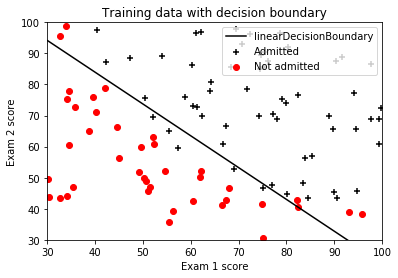

In [205]:
#Plot the decision boundary
plotDecisionBoundary(theta,X,y)
plt.title("Training data with decision boundary")
plt.show()
#print(X)

### 1.2.4 Evaluating logistic regression
After learning the parameters,you can use the model to predict whether a particular student will be admitted.For a student with an Exam 1 score of 45 and an Exam 2 score of 85,you should expect to see an admission probability of 0.776.
Another way to evaluate the quality of the parameters we have found
is to see how well the learned model predicts on our training set. In this part, your task is to complete the code in predict.m. The predict function will produce “1” or “0” predictions given a dataset and a learned parameter vector θ.
After you have completed the code in predict.m, the ex2.m script will
proceed to report the training accuracy of your classifier by computing the percentage of examples it got correct.

In [206]:
#Part 4: Predict and Accuracies
#In this part,you will use the logistic regression model to predict the 
#probability that a student with score 45 on exam 1 and score 85 on exam
# 2 will be admitted.
prob = sigmoid(np.dot(np.array([[1,45,85]]),theta))
print("For a student with scores 45 and 85,we predict an admission \
probability of" + str(prob))
print("Expected value: 0.775 +/- 0.002")

for i in range(4):
    print(X[i,:].reshape((1,3)))
print(theta)


For a student with scores 45 and 85,we predict an admission probability of[[ 0.77629072]]
Expected value: 0.775 +/- 0.002
[[  1.          34.62365962  78.02469282]]
[[  1.          30.28671077  43.89499752]]
[[  1.          35.84740877  72.90219803]]
[[  1.          60.18259939  86.3085521 ]]
[[-25.16133284]
 [  0.2062317 ]
 [  0.2014716 ]]


In [207]:
"""
# Predict
def predict(theta, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic 
    regression parameters theta.
    p = predict(theta,X) computers the predictions for X using a 
    threshold at 0.5 (i.e.,if sigmoid(np.dot(X,theta))>=0.5,predict 1)
    '''
    m = X.shape[0]
    #You need to return the following variables correctly
    p = np.zeros((m,1))
    #complete the following code to make predictions using your learned
    #logistic regression parameters.You should set p to a vector of 0 and 1
    for i in range(m):
        h = 1 / (1 + np.exp(-np.dot(X[i,:].reshape((1,3)),theta)))
        if h < 0.5:
            p[i][0] = 0
        else:
            p[i][0] = 1
    
    print("p.shape = " + str(p.shape))
    return p
"""

'\n# Predict\ndef predict(theta, X):\n    \'\'\'\n    Predict whether the label is 0 or 1 using learned logistic \n    regression parameters theta.\n    p = predict(theta,X) computers the predictions for X using a \n    threshold at 0.5 (i.e.,if sigmoid(np.dot(X,theta))>=0.5,predict 1)\n    \'\'\'\n    m = X.shape[0]\n    #You need to return the following variables correctly\n    p = np.zeros((m,1))\n    #complete the following code to make predictions using your learned\n    #logistic regression parameters.You should set p to a vector of 0 and 1\n    for i in range(m):\n        h = 1 / (1 + np.exp(-np.dot(X[i,:].reshape((1,3)),theta)))\n        if h < 0.5:\n            p[i][0] = 0\n        else:\n            p[i][0] = 1\n    \n    print("p.shape = " + str(p.shape))\n    return p\n'

In [208]:
"""
#Computer accuracy on our training set
print(theta.shape, X.shape)
p = predict(theta,X)
sum = 0
for i in range(m):
    if p[i][0] == y[i][0]:
        sum += 1
print(sum/m)
#print(p)
"""
"""
(3, 1) (100, 3)
p.shape = (100, 1)
0.89
"""

'\n(3, 1) (100, 3)\np.shape = (100, 1)\n0.89\n'

 - **在predict函数这里，你用的是for循环，如果数据多的时候，for循环效果不好。要学会用矩阵来整体处理。**

In [209]:
#重新定义一下这个Predict函数
def predict(theta,X):
    """
    Predict whether the label is 0 or 1 using learning logistic regression
    parameters theta.
    p = predict(theta,X) computes the predictions for X using a threshold
    at 0.5 (i.e.,if sigmoid(theta'*x) >= 0.5,predict 1)
    """
    #Number of training examples
    m = X.shape[0]
    #You need to return the following variables correctly
    p = np.zeros((m,1))
    #注意一定要分清谁的转置乘以谁，或者有没有转置
    h = sigmoid(np.dot(X,theta))
    index = h >= 0.5
    p[index] = 1
    #炸，为什么老想不到简单的表示方法
    #p[h >= 0.5] = 1
    return p

In [210]:
#Compute accuracy on our training set
p = predict(theta,X)
accuracy = np.mean(p==y)
print('Train Accuracy:'+str(accuracy))
print("Expected accuracy (approx): 0.89")

Train Accuracy:0.89
Expected accuracy (approx): 0.89


## 2 Regularized logistic regression
In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests,you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.
You will use another script, ex2 reg.m to complete this portion of the
exercise.

## 2.1 Visualizing the data
Similar to the previous parts of this exercise,plotData is used to generate a figure like Figure3,where the axes are the two test scores,and the positive (y=1,accepted) and negative (y=0,rejected) examples are shown with different markers.
Figure 3 shows that our dataset cannot be separated into positive and
negative examples by a straight-line through the plot. Therefore, a straightforward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.


In [211]:
#Machine Learning Online Class - Exercise 2:Logistic Regression
"""
Instructions 
This file contains code that helps you get started on the second part
 of the exercise which covers regularization with logistic regression.
You will need to complete the following functions in this exercise:
       sigmoid.m
       costFuntion.m
       predict.m
       costFunctionReg.m
For this exercise,you will not need to change any code in this file,
or any other files other than those mentioned above.
"""
# Load Data
#The first two columns contains the X values and the third column contains
#the label(y).
# - column 1:score of microchip test 1
# - column 2:score of microchip test 2
# - column 3:accepted (1) or not (0)
data_reg = np.loadtxt('ex2data2.txt',delimiter=',')

X_reg , y_reg = np.hsplit(data_reg,np.array([2]))
#print(X_reg)
#print(y)
#print(X_reg.shape)

In [212]:
#plot Data
def plotData2(X,y,x1label='y=1',x2label='y=0'):
    pos = np.squeeze(y == 1)
    neg = np.squeeze(y == 0)
    plt.scatter(X[pos][:,0],X[pos][:,1],c='k',marker='+',label=x1label)
    plt.scatter(X[neg][:,0],X[neg][:,1],c='r',marker='o',label=x2label)
    plt.title("Figure 3:Plot of training data")
    plt.xlabel('Microchip Test1')
    plt.ylabel('Microchip Test2')
    plt.legend()
    
    #注意这两行可以设置横轴和纵轴的范围
    plt.xlim(-1,1.5,0.5)
    plt.ylim(-0.8,1.2,0.2)

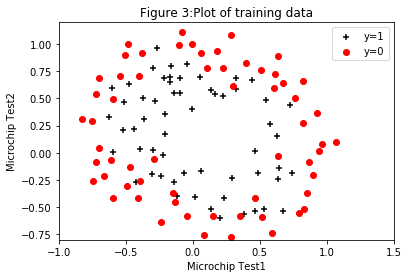

In [213]:
plotData2(X_reg,y_reg)

## 2.2 Feature mapping
One way to fit the data better is to create more features from each datapoint. In the provided function mapFeature.m, we will map the features intoall polynomial terms of x 1 and x 2 up to the sixth power.
$$mapFeature(x) = \left[\begin{array}{c} 1 \\ {x}_{1} \\ {x}_{2} \\ {{x}_{1}}^{2} \\ {x}_{1}{x}_{2} \\ {{x}_{2}}^{2} \\ {{x}_{1}}^{3} \\ \vdots \\ {x}_{1}{{x}_{2}}^{5} \\ {{x}_{2}}^{6} \end{array}\right]$$

As a result of this mapping, our vector of two features (the scores on
two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.
While the feature mapping allows us to build a more expressive classifier,it also more susceptible to overfitting. In the next parts of the exercise, you will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.

#  Part1:Regularized Logistic Regression
In this part, you are given a dataset with data points that are notlinearly separable. However, you would still like to use logistic regression to classify the data points.
To do so, you introduce more features to use -- in particular, you addpolynomial features to our data matrix (similar to polynomial regression).
Add Polynomial Features
Note that mapFeature also adds a column of ones for us, so the intercept term is handled

In [214]:
#Feature Mapping
#目的就是经过两个特征组合变成多个特征
def mapFeature(X1,X2):
    """
    MAPFEATURE Feature mapping function to polynomial features
    mapFeature(X1,X2) maps the two input features to quadratic features
    used in the regularization exercise.
    Returns a new feature array with more features,comprising of 
    X1,X2,X1.^2,X2.^2,X1*X2,X1*X2.^2,etc....
    Inputs X1,X2 must be the same size
    """
    degree = 6
    out = np.ones((X1.shape[0],1))
    for i in range(1,degree + 1):
        for j in range(i + 1):
            out = np.hstack((out, np.power(X1,(i-j)) * np.power(X2,j)))
    return out

In [215]:
#把X的两列分成X1,X2，并且它们都是列向量,然后再让它们组合
X_reg = mapFeature(X_reg[:,[0]],X_reg[:,[1]])
#print(X_reg)
#print(X_reg.shape)

## 2.3 Cost function and gradient
Now you will implement code to compute the cost function and gradient for regularized logistic regression. Complete the code in costFunctionReg.m to return the cost and gradient.
Recall that the regularized cost function in logistic regression is
$$J(\theta)=\frac{1}{m}\sum_{i=1}^{m}[-{y}^{(i)}\log({h}_{\theta}({x}^{(i)}))-(1-{y}^{(i)})\log(1-{h}_{\theta}({x}^{(i)}))]+\frac{\lambda}{2m}\sum_{j=1}^{n}{{\theta}_{j}}^{2}$$
Note that you should not regularize the parameter ${\theta}_{0}$。
The gradient of the cost function is a vector where the ${j}^{th}$ element is defined as follows:
$$\frac{\partial j(\theta)}{\partial {\theta}_{0}} = \frac{1}{m}\sum_{i=1}^{m}({h}_{\theta}({x}^{(i)})-{y}^{(i)}){{x}_{j}}^{(i)} \qquad \text{for }  j = 0 $$ 
$$\frac{\partial j(\theta)}{\partial {\theta}_{0}} = \left(\frac{1}{m}\sum_{i=1}^{m}({h}_{\theta}({x}^{(i)})-{y}^{(i)}){{x}_{j}}^{(i)}\right) + \frac{\lambda}{m}{\theta}_{j} \qquad \text{for }  j \geq 1$$
Once you are done, the script will call your costFunctionReg function using the initial value of $\theta$ (initialized to all zeros). You should see that the cost is about 0.693.

In [216]:
def costFunctionReg(theta, X, y, lamda):
    """
    COSTFUNCTIONREG Computer cost and gradient for logistic regression 
    with regularization theta as the parameter for regularized logistic
    regression and the gradient of the cost w.r.t. to the parameters.
    """
    #Initialize some useful values
    #Arguments theta and y may be rank 1 array
    #这里其实不用加，因为theta和y都是(m,1)array
    theta = theta.reshape((theta.shape[0],1))
    y = y.reshape((y.shape[0],1))
    m = X.shape[0] #number of training examples
    #You need to return the following variables correctly
    J = 0
    grad = np.zeros((theta.shape[0]))
    """
    Instructions:Compute the cost of a particular choice of theta.
    You should set J to the cost.
    Compute the partial derivatives and set grad to the partial 
    derivatives of the cost w.r.t. each parameter in theta
    """
    J=-1.0*(np.dot(y.T,np.log(sigmoid(np.dot(X,theta))))\
          +np.dot((1-y).T,np.log(1-sigmoid(np.dot(X,theta)))))/m\
            + lamda*np.sum(np.power(theta,2))/(2*m)
    #后面调用minimize函数，需要行向量，一个列表，所以变一下
    J = np.squeeze(J)
    
    #Compute the gradients
    grads = np.dot(X.T,sigmoid(np.dot(X,theta))-y) / m + lamda*theta/m
    grads[0] = grads[0] - lamda*theta[0] / m
    #Return J and grads(注意这里要把grads变为一个列表，由于后面的minimize函数需要) 
    return J, grads.ravel()

In [217]:
#Get the number of examples  (m) and the number of features (n)
m, n = X_reg.shape
print("The number of training examples: " + str(m))
print("The number of features: " + str(n))

#Initialize fitting parameters
initial_theta = np.zeros((n,1))

#Set regularization parameter lambda to 1
lamda = 1

#Computer and display initial cost and gradient for regularized logistic regression
cost , grad = costFunctionReg(initial_theta,X_reg,y_reg,lamda)
print('Cost at initial theta (zeros): ' + str(cost))
print('Expected cost (approx): 0.693')
print("Gradient at initial theta (zeros) - first five values only:")
print(grad[0:5].reshape((5,1)))#注意这里可以转化为一个列向量
print("Expcted gradients (approx) - first five values only:")
print(np.array([[0.0085],[0.0188],[0.0001],[0.0503],[0.0115]]))

#Compute and display cost and gradient with all-ones theta and lambda = 10
test_theta = np.ones((X_reg.shape[1],1))
lamda = 10
cost , grad = costFunctionReg(test_theta,X_reg,y_reg,lamda)
print('Cost at test theta (with lambda = 10): ' + str(cost))
print('Expected cost (approx): 3.16')
print("Gradient at test theta (ones) - first five values only:")
print(grad[0:5].reshape((5,1)))#注意这里可以转化为一个列向量
print("Expcted gradients (approx) - first five values only:")
print(np.array([[0.3460],[0.1614],[0.1948],[0.2269],[0.0922]]))

The number of training examples: 118
The number of features: 28
Cost at initial theta (zeros): 0.6931471805599453
Expected cost (approx): 0.693
Gradient at initial theta (zeros) - first five values only:
[[  8.47457627e-03]
 [  1.87880932e-02]
 [  7.77711864e-05]
 [  5.03446395e-02]
 [  1.15013308e-02]]
Expcted gradients (approx) - first five values only:
[[ 0.0085]
 [ 0.0188]
 [ 0.0001]
 [ 0.0503]
 [ 0.0115]]
Cost at test theta (with lambda = 10): 3.206882212970942
Expected cost (approx): 3.16
Gradient at test theta (ones) - first five values only:
[[ 0.34604507]
 [ 0.16135192]
 [ 0.19479576]
 [ 0.22686278]
 [ 0.09218568]]
Expcted gradients (approx) - first five values only:
[[ 0.346 ]
 [ 0.1614]
 [ 0.1948]
 [ 0.2269]
 [ 0.0922]]


## 2.3.1 Learning parameters using minimize
Similar to the previous parts, you will use minimize to learn the optimal parameters θ. If you have completed the cost and gradient for regularized logistic regression (costFunctionReg.m) correctly, you should be able to step through the next part of ex2 reg.m to learn the parameters θ using minimize.

# Part 2 : Regularization and Accuracies 
Optional Exercise:
In this part, you will get to try different values of lambda andsee how regularization affects the decision coundart.
Try the following values of lambda (0, 1, 10, 100).
How does the decision boundary change when you vary lambda? How doesthe training set accuracy vary?

In [218]:
#Initialize fitting parameters
initial_theta = np.zeros((X_reg.shape[1],1))
#Set regularization parameters lamda to 1
lamda = 1

optimizeResult = minimize(fun=costFunctionReg, x0= initial_theta.ravel(),\
                         args=(X_reg,y_reg.ravel(),lamda),\
                         method='BFGS',jac=True,options={'maxiter':400})

#Print optimizeResult
theta = optimizeResult.x
theta = theta.reshape((theta.shape[0],1))
cost = optimizeResult.fun

# Compute accuracy on our training set
p = predict(theta,X_reg)
accuracy = np.mean(p == y_reg)
print('Train Accuracy:'+str(accuracy))
print("Expected accuracy (with lamda = 1, approx): 0.83")

Train Accuracy:0.830508474576
Expected accuracy (with lamda = 1, approx): 0.83


## 2.4 Plotting the decision boundary
To help you visualize the model learned by this classifier, we have provided the function plotDecisionBoundary.m which plots the (non-linear)decision boundary that separates the positive and negative examples. In plotDecisionBoundary.m, we plot the non-linear decision boundary by computing the classifier’s predictions on an evenly spaced grid and then and drew a contour plot of where the predictions change from y = 0 to y = 1.
After learning the parameters θ, the next step in ex reg.m will plot a decision boundary similar to Figure 4.

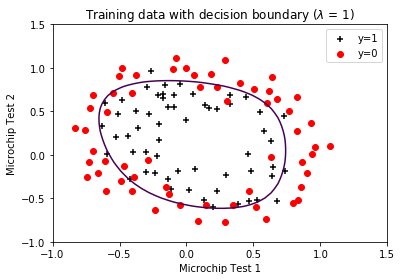

In [219]:
plotDecisionBoundary(theta,X_reg,y_reg,1)
plt.show()

## 2.5 Optional (ungraded) exercises
In this part of the exercise, you will get to try out different regularization parameters for the dataset to understand how regularization prevents overfitting.
Notice the changes in the decision boundary as you vary λ. With a small λ, you should find that the classifier gets almost every training example correct, but draws a very complicated boundary, thus overfitting the data(Figure 5). This is not a good decision boundary: for example, it predicts that a point at x = (−0.25, 1.5) is accepted (y = 1), which seems to be an incorrect decision given the training set.
With a larger λ, you should see a plot that shows an simpler decision boundary which still separates the positives and negatives fairly well. However, if λ is set to too high a value, you will not get a good fit and the decision boundary will not follow the data so well, thus underfitting the data (Figure6).

In [220]:
#这里最好定义一个构造函数，不同的lamda对应不同的边界
def model(X,y,lamda,initial_theta):
    # Optimizing using minimize
    optimizeResult = minimize(fun=costFunctionReg,x0=initial_theta.ravel(),\
                             args=(X,y.ravel(),lamda), method='BFGS',jac=True,\
                             options={'maxiter':400})
    theta = optimizeResult.x
    theta = theta.reshape((theta.shape[0],1))
    return theta

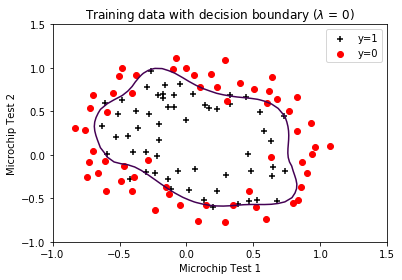

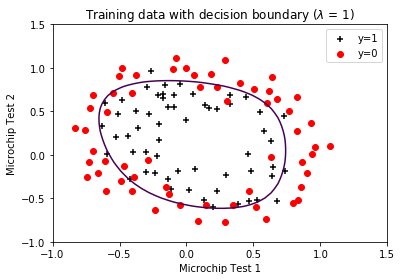

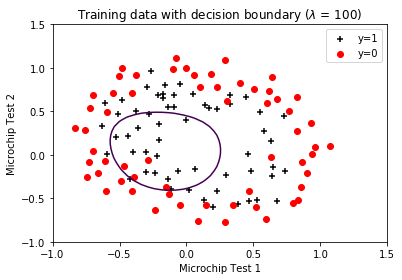

In [221]:
#Initialze fitting parameters
initial_theta = np.zeros((X_reg.shape[1],1))
#Set parameter lamda
lamdaArray = [0, 1, 100]

for lamda in lamdaArray:
    theta = model(X_reg,y_reg,lamda,initial_theta)
    plotDecisionBoundary(theta,X_reg,y_reg,lamda)
    plt.show()